<a href="https://colab.research.google.com/github/adamd1985/Lectures_On_MLAI/blob/main/4_2_Logistic_Regression_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Logistic Regression with Binary and Multiclass Classification

## Introduction
Unlike linear regression, logistic regression models the probability of a target variable belonging to a specific class. It is suitable for both binary and multiclass classification tasks. Logistic regression uses the **sigmoid function** to ensure the output lies between 0 and 1.

In [122]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

The breast cancer dataset, available [here](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).

- **mean radius**: Mean of distances from center to points on the perimeter
- **mean texture**: Standard deviation of gray-scale values
- **mean perimeter**: Mean size of the core tumor perimeter
- **mean area**: Mean size of the core tumor area
- **mean smoothness**: Mean of local variation in radius lengths                |
- Target: **0**: Malignant (Cancerous) or **1**: Benign (Non-Cancerous)


In [123]:
breast_cancer_df = load_breast_cancer(as_frame=True).frame

breast_cancer_df.sample(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
558,14.59,22.68,96.39,657.1,0.08473,0.13300,0.10290,0.03736,0.1454,0.06147,...,27.27,105.90,733.5,0.1026,0.3171,0.3662,0.11050,0.2258,0.08004,1
410,11.36,17.57,72.49,399.8,0.08858,0.05313,0.02783,0.02100,0.1601,0.05913,...,36.32,85.07,521.3,0.1453,0.1622,0.1811,0.08698,0.2973,0.07745,1
72,17.20,24.52,114.20,929.4,0.10710,0.18300,0.16920,0.07944,0.1927,0.06487,...,33.82,151.60,1681.0,0.1585,0.7394,0.6566,0.18990,0.3313,0.13390,0


Visualization of 2 features and their relationship with the label.

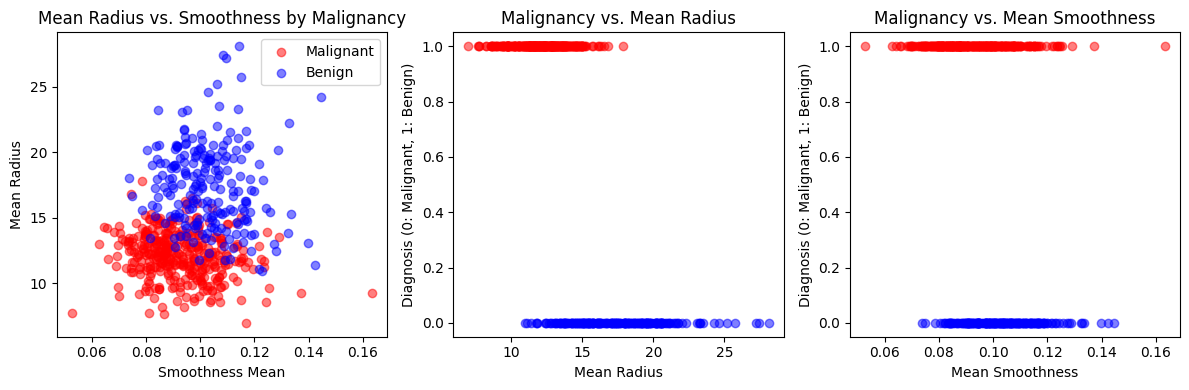

In [124]:
mal = breast_cancer_df[breast_cancer_df["target"] == 1]
ben = breast_cancer_df[breast_cancer_df["target"] == 0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].scatter(mal['mean smoothness'], mal['mean radius'], color='red', alpha=0.5, label='Malignant')
axes[0].scatter(ben['mean smoothness'], ben['mean radius'], color='blue', alpha=0.5, label='Benign')
axes[0].set_xlabel('Smoothness Mean')
axes[0].set_ylabel('Mean Radius')
axes[0].set_title('Mean Radius vs. Smoothness by Malignancy')
axes[0].legend()

axes[1].scatter(mal['mean radius'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[1].scatter(ben['mean radius'], ben['target'], color='blue', alpha=0.5, label='Benign')
axes[1].set_xlabel('Mean Radius')
axes[1].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[1].set_title('Malignancy vs. Mean Radius')

axes[2].scatter(mal['mean smoothness'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[2].scatter(ben['mean smoothness'], ben['target'], color='blue', alpha=0.5, label='Benign')
axes[2].set_xlabel('Mean Smoothness')
axes[2].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[2].set_title('Malignancy vs. Mean Smoothness')

plt.tight_layout()
plt.show()

A Linear Regression cannot capture the relationship between these variables and the label.

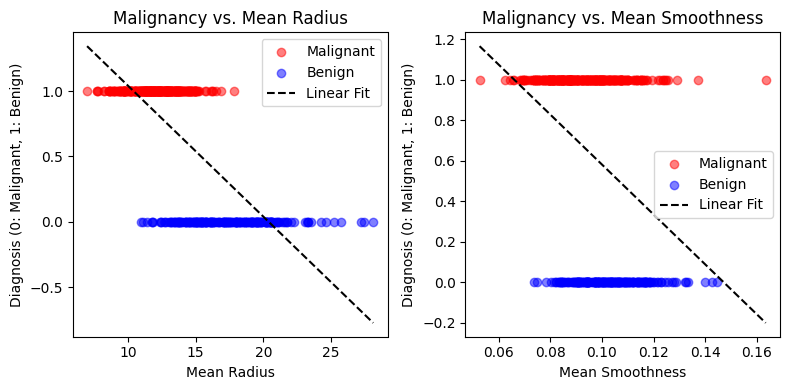

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].scatter(mal['mean radius'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[0].scatter(ben['mean radius'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean radius'].min(), breast_cancer_df['mean radius'].max(), 100)
y_vals = np.poly1d(np.polyfit(breast_cancer_df['mean radius'], breast_cancer_df['target'], 1))(x_vals)
axes[0].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Linear Fit')

axes[0].set_xlabel('Mean Radius')
axes[0].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[0].set_title('Malignancy vs. Mean Radius')
axes[0].legend()

axes[1].scatter(mal['mean smoothness'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[1].scatter(ben['mean smoothness'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean smoothness'].min(), breast_cancer_df['mean smoothness'].max(), 100)
y_vals = np.poly1d(np.polyfit(breast_cancer_df['mean smoothness'], breast_cancer_df['target'], 1))(x_vals)
axes[1].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Linear Fit')

axes[1].set_xlabel('Mean Smoothness')
axes[1].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[1].set_title('Malignancy vs. Mean Smoothness')
axes[1].legend()

plt.tight_layout()
plt.show()


## Logistic Regression


We prepare our data

In [126]:
X = breast_cancer_df[['mean radius']].values
y = breast_cancer_df['target'].values
X_bias = np.column_stack((np.ones(X.shape[0]), X))

betas = np.zeros(X_bias.shape[1])

### Sigmoid Function

The logistic (sigmoid) function maps any real-valued number into the range $(0,1) $:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

where $z $ is the linear combination of weights and input features:

$$
z = \beta_0 + \sum_j \beta_j x_{ij}
$$

In [127]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Maximum Likelihood Estimation (MLE)

We estimate the parameters $\beta $ by maximizing the likelihood function:

$$
L(\beta) = \prod_{i=1}^{m} p(X_i)^{y_i} (1 - p(X_i))^{(1 - y_i)}
$$

Taking the logarithm for computational efficiency:

$$
\log L(\beta) = \sum_{i=1}^{m} y_i \log p(X_i) + (1 - y_i) \log (1 - p(X_i))
$$

To find the optimal values of $\beta $, we compute the gradient:

$$
\frac{\partial \log L}{\partial \beta_j} = \sum_{i=1}^{m} (y_i - p(X_i)) x_{ij}
$$

Using gradient descent, we iteratively update the weights:

$$
\beta_j := \beta_j + \alpha \sum_{i=1}^{m} (y_i - p(X_i)) x_{ij}
$$

where:
- $\alpha $ is the learning rate.
- The term $(y_i - p(X_i)) $ represents the error between the true label and the predicted probability.

In [128]:
def compute_log_likelihood(X, y, betas):
    m = len(y)
    h = sigmoid(X @ betas)
    return np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))


### Gradient Ascent for Logistic Regression

To optimize $J(\beta) $ (log-likelihood), we use **gradient ascent**:

$$
\beta := \beta + \alpha \frac{\partial \log L}{\partial \beta}
$$

which updates the parameters iteratively to **maximize** the log-likelihood function:

$$
\log L(\beta) = \sum_{i=1}^{m} y_i \log p(X_i) + (1 - y_i) \log (1 - p(X_i))
$$

where:

$$
\frac{\partial \log L}{\partial \beta_j} = \sum_{i=1}^{m} (y_i - p(X_i)) x_{ij}
$$

The update rule for **gradient ascent** is:

$$
\beta_j := \beta_j + \alpha \sum_{i=1}^{m} (y_i - p(X_i)) x_{ij}
$$

where:
- $\alpha $ is the learning rate.
- $(y_i - p(X_i)) $ is the error term.
- $x_{ij} $ are the feature values.

This process ensures the parameters are updated iteratively to **maximize** the log-likelihood function.


In [129]:
def gradient_ascent_mle(X, y, betas, learning_rate=0.01, epochs=100, clip_value=1):
    log_likelihood_history = []
    for _ in range(epochs):
        h = sigmoid(X @ betas)
        gradient = X.T @ (y - h)
        gradient = np.clip(gradient, -clip_value, clip_value)  # Exploding Gradient
        betas += learning_rate * gradient
        log_likelihood_history.append(compute_log_likelihood(X, y, betas))
    return betas, log_likelihood_history

We train our gradient ascent and find the betas

In [130]:
betas_opt_mle, log_likelihood_history = gradient_ascent_mle(X_bias, y, betas, learning_rate=0.002, epochs=1000)
betas_opt_mle

array([ 2.        , -0.12413734])

### Predict with Logistic Regression

The probability of the target belonging to class 1, given the input features $X $, is given by:

$$
p(X) = \frac{\exp(\beta_0 + \sum_j \beta_j x_{ij})}{1 + \exp(\beta_0 + \sum_j \beta_j x_{ij})}
$$

where:
- $p(X) $ is the probability that the instance belongs to class 1.
- $\beta_0 $ is the intercept (bias).
- $\beta_j $ are the coefficients (weights).
- $x_{ij} $ represents the feature values.



In [131]:
def predict(X, betas):
    return sigmoid(X @ betas) >= 0.5

predictions = predict(X_bias, betas_opt_mle)
accuracy = np.mean(predictions == y)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8471


# Classification Metrics Formulas

Accuracy
$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$

Precision
$
Precision = \frac{TP}{TP + FP}
$

Recall (Sensitivity)
$
Recall = \frac{TP}{TP + FN}
$

Specificity
$
Specificity = \frac{TN}{TN + FP}
$

F1-Score
$
F1 = \frac{2 \times Precision \times Recall}{Precision + Recall}
$

ROC Curve Components
$
TPR = \frac{TP}{TP + FN}
$
$
FPR = \frac{FP}{FP + TN}
$

AUC (Area Under the Curve)
$
AUC = \int_{0}^{1} TPR \, d(FPR)
$


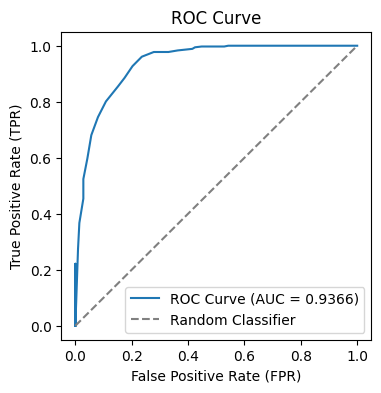

,Metric,Value
0,Accuracy,0.847100
1,Precision,0.812500
2,Recall (Sensitivity),0.983193
3,Specificity,0.617925
4,F1-Score,0.889734
5,AUC,0.936625


In [132]:
def get_classification_metrics(predictions, y, X_bias, betas_opt_mle):
    TP = np.sum((predictions == 1) & (y == 1))
    TN = np.sum((predictions == 0) & (y == 0))
    FP = np.sum((predictions == 1) & (y == 0))
    FN = np.sum((predictions == 0) & (y == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    thresholds = np.linspace(0, 1, 100)
    tpr_values = []
    fpr_values = []

    for t in thresholds:
        predictions_t = sigmoid(X_bias @ betas_opt_mle) >= t
        TP_t = np.sum((predictions_t == 1) & (y == 1))
        TN_t = np.sum((predictions_t == 0) & (y == 0))
        FP_t = np.sum((predictions_t == 1) & (y == 0))
        FN_t = np.sum((predictions_t == 0) & (y == 1))

        tpr_values.append(TP_t / (TP_t + FN_t) if (TP_t + FN_t) > 0 else 0)
        fpr_values.append(FP_t / (FP_t + TN_t) if (FP_t + TN_t) > 0 else 0)

    sorted_indices = np.argsort(fpr_values)
    fpr_values = np.array(fpr_values)[sorted_indices]
    tpr_values = np.array(tpr_values)[sorted_indices]
    auc = np.trapz(tpr_values, x=fpr_values)  # Approx trapezoidal rule

    metrics = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall (Sensitivity)", "Specificity", "F1-Score", "AUC"],
        "Value": [accuracy, precision, recall, specificity, f1_score, auc],
    })

    return metrics, tpr_values, fpr_values

metrics, tpr_values, fpr_values = get_classification_metrics(predictions, y, X_bias, betas_opt_mle)

plt.figure(figsize=(4, 4))
plt.plot(fpr_values, tpr_values, linestyle='-', label=f'ROC Curve (AUC = {metrics.loc[metrics["Metric"] == "AUC", "Value"].values[0]:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

metrics

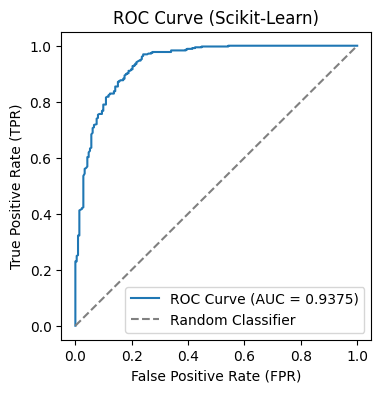

,Metric,Value
0,Accuracy,0.878735
1,Precision,0.880952
2,Recall (Sensitivity),0.932773
3,Specificity,NaN
4,F1-Score,0.906122
5,AUC,0.937517


In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score


log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X, y)


y_pred = log_reg.predict(X)
y_pred_prob = log_reg.predict_proba(X)[:, 1]


accuracy_sklearn = accuracy_score(y, y_pred)
precision_sklearn = precision_score(y, y_pred)
recall_sklearn = recall_score(y, y_pred)
f1_sklearn = f1_score(y, y_pred)

fpr_sklearn, tpr_sklearn, _ = roc_curve(y, y_pred_prob)
auc_sklearn = auc(fpr_sklearn, tpr_sklearn)
metrics_sklearn = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall (Sensitivity)", "Specificity", "F1-Score", "AUC"],
    "Value": [accuracy_sklearn, precision_sklearn, recall_sklearn, np.nan, f1_sklearn, auc_sklearn],
})


plt.figure(figsize=(4, 4))
plt.plot(fpr_sklearn, tpr_sklearn, linestyle='-', label=f'ROC Curve (AUC = {auc_sklearn:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Scikit-Learn)')
plt.legend()
plt.show()

metrics_sklearn

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



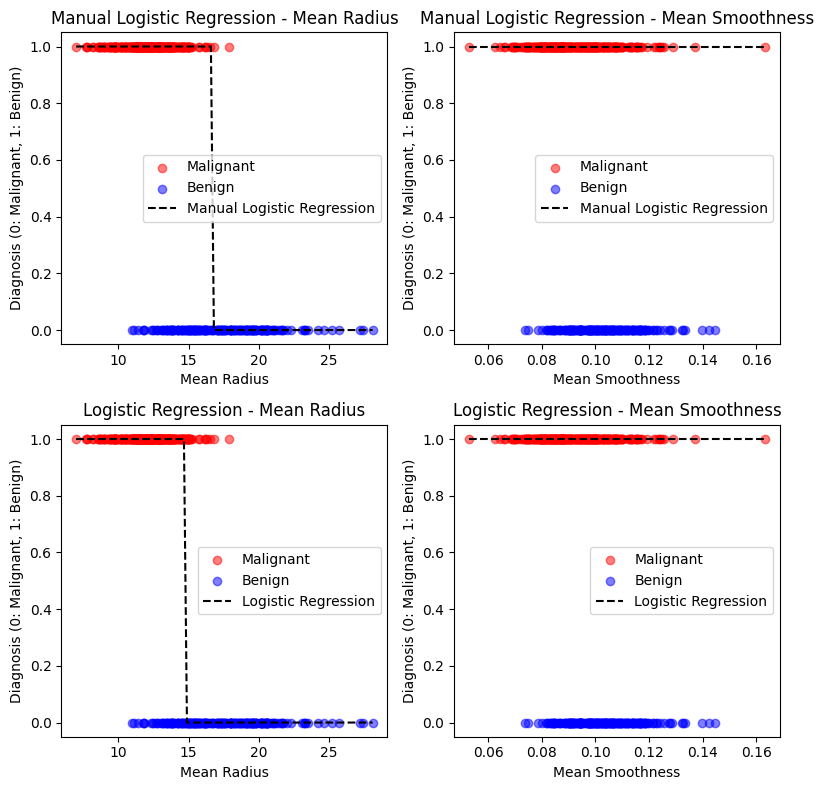

In [134]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Manually Implemented Logistic Regression - Mean Radius
X_radius = breast_cancer_df[['mean radius']].values
X_radius_bias = np.c_[np.ones(X_radius.shape[0]), X_radius]
betas_radius = np.zeros(X_radius_bias.shape[1])
betas_opt_radius, _ = gradient_ascent_mle(X_radius_bias, y, betas_radius)

axes[0, 0].scatter(mal['mean radius'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[0, 0].scatter(ben['mean radius'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean radius'].min(), breast_cancer_df['mean radius'].max(), 100)
y_vals = predict(np.c_[np.ones(len(x_vals)), x_vals], betas_opt_radius).astype(int)

axes[0, 0].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Manual Logistic Regression')
axes[0, 0].set_xlabel('Mean Radius')
axes[0, 0].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[0, 0].set_title('Manual Logistic Regression - Mean Radius')
axes[0, 0].legend()

# Manually Implemented Logistic Regression - Mean Smoothness
X_smooth = breast_cancer_df[['mean smoothness']].values
X_smooth_bias = np.c_[np.ones(X_smooth.shape[0]), X_smooth]
betas_smooth = np.zeros(X_smooth_bias.shape[1])
betas_opt_smooth, _ = gradient_ascent_mle(X_smooth_bias, y, betas_smooth)

axes[0, 1].scatter(mal['mean smoothness'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[0, 1].scatter(ben['mean smoothness'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean smoothness'].min(), breast_cancer_df['mean smoothness'].max(), 100)
y_vals = predict(np.c_[np.ones(len(x_vals)), x_vals], betas_opt_smooth).astype(int)

axes[0, 1].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Manual Logistic Regression')
axes[0, 1].set_xlabel('Mean Smoothness')
axes[0, 1].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[0, 1].set_title('Manual Logistic Regression - Mean Smoothness')
axes[0, 1].legend()

# Scikit-Learn Logistic Regression - Mean Radius
log_reg_radius = LogisticRegression(solver='lbfgs')
log_reg_radius.fit(breast_cancer_df[['mean radius']], y)

axes[1, 0].scatter(mal['mean radius'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[1, 0].scatter(ben['mean radius'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean radius'].min(), breast_cancer_df['mean radius'].max(), 100).reshape(-1, 1)
y_vals = log_reg_radius.predict(x_vals)

axes[1, 0].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Logistic Regression')
axes[1, 0].set_xlabel('Mean Radius')
axes[1, 0].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[1, 0].set_title('Logistic Regression - Mean Radius')
axes[1, 0].legend()

# Scikit-Learn Logistic Regression - Mean Smoothness
log_reg_smooth = LogisticRegression(solver='lbfgs')
log_reg_smooth.fit(breast_cancer_df[['mean smoothness']], y)

axes[1, 1].scatter(mal['mean smoothness'], mal['target'], color='red', alpha=0.5, label='Malignant')
axes[1, 1].scatter(ben['mean smoothness'], ben['target'], color='blue', alpha=0.5, label='Benign')

x_vals = np.linspace(breast_cancer_df['mean smoothness'].min(), breast_cancer_df['mean smoothness'].max(), 100).reshape(-1, 1)
y_vals = log_reg_smooth.predict(x_vals)

axes[1, 1].plot(x_vals, y_vals, color='black', linestyle='dashed', label='Logistic Regression')
axes[1, 1].set_xlabel('Mean Smoothness')
axes[1, 1].set_ylabel('Diagnosis (0: Malignant, 1: Benign)')
axes[1, 1].set_title('Logistic Regression - Mean Smoothness')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

As a 3D regression. In this one we will do a multivariable regression using both mean radius and smoothness combines.

In [135]:
X = breast_cancer_df[['mean radius', 'mean smoothness']].values
y = breast_cancer_df['target'].values

X_bias = np.column_stack((np.ones(X.shape[0]), X))

betas = np.zeros(X_bias.shape[1])
betas_opt_features, log_likelihood_history_features = gradient_ascent_mle(X_bias, y, betas)
betas_opt_features

array([ 1.        , -0.06      ,  0.99819789])

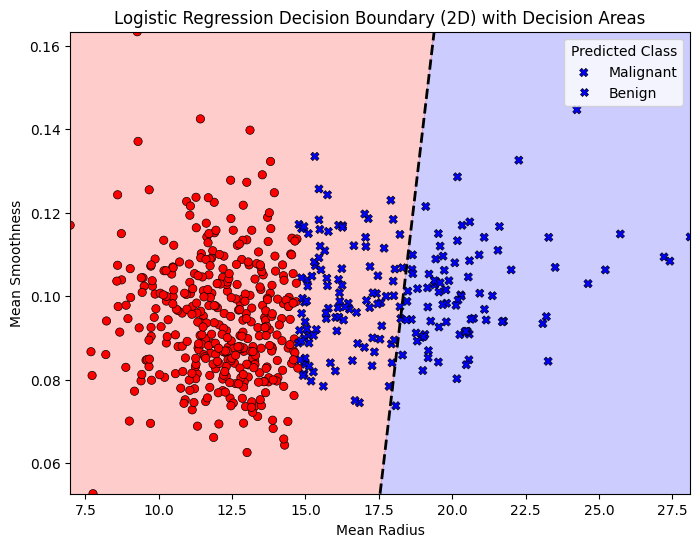

In [136]:
radius_vals = np.linspace(breast_cancer_df['mean radius'].min(), breast_cancer_df['mean radius'].max(), 100)
smoothness_vals = np.linspace(breast_cancer_df['mean smoothness'].min(), breast_cancer_df['mean smoothness'].max(), 100)
radius_mesh, smoothness_mesh = np.meshgrid(radius_vals, smoothness_vals)

# Compute predicted probabilities for the grid
X_mesh = np.column_stack((np.ones(radius_mesh.ravel().shape[0]), radius_mesh.ravel(), smoothness_mesh.ravel()))
z_vals = sigmoid(X_mesh @ betas_opt_features).reshape(radius_mesh.shape)

# Plot the decision boundary with shaded regions for classification areas

plt.figure(figsize=(8, 6))

# Fill decision regions based on prediction probabilities
plt.contourf(radius_mesh, smoothness_mesh, z_vals, levels=[0, 0.5, 1], colors=['blue', 'red'], alpha=0.2)

# Plot decision boundary using contour where the probability is 0.5
plt.contour(radius_mesh, smoothness_mesh, z_vals, levels=[0.5], colors='black', linewidths=2, linestyles='dashed')

# Scatter plot of actual data points with predicted labels
sns.scatterplot(
    x=breast_cancer_df['mean radius'],
    y=breast_cancer_df['mean smoothness'],
    hue=y_pred,
    palette={0: 'blue', 1: 'red'},
    style=y_pred,
    markers={0: 'X', 1: 'o'},
    edgecolor='black'
)

# Labels and title
plt.xlabel('Mean Radius')
plt.ylabel('Mean Smoothness')
plt.title('Logistic Regression Decision Boundary (2D) with Decision Areas')

plt.legend(title='Predicted Class', labels=['Malignant', 'Benign'])
plt.show()


Is it balacnced?

In [137]:
breast_cancer_df['target'].value_counts().to_frame().rename(columns={'target': 'count'})

,count
target,
1,357
0,212


## Imbalanced Data Regression

The dataset from scikit learn is mostly balanced. Let's use [opendatasets](https://github.com/JovianHQ/opendatasets)

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/mlg-ulb/creditcardfraud")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: